# Prediction of Synaptic Clusters in Inhibitory Neurons  
### *Supervised learning using K-Nearest Neighbors, Random Forest, and XGBoost*

## I. Introduction

* The aim of this project is to train supervised machine learning models to predict the cluster membership of newly observed synapses belonging to inhibitory neurons.

* The models are trained using the clustering results obtained in a previous project, where historical synapse data were analyzed using an unsupervised UMAP–HDBSCAN approach. These previously identified clusters serve as labels for supervised learning.

* Several supervised learning algorithms were evaluated to determine which models provide the most reliable predictions across different synapse types and neuronal subgroups.

## II. Objectives

* To compare the performance of different supervised models across distinct investigation groups.  K-Nearest Neighbors (KNN) and tree-based models (Random Forest and XGBoost) were evaluated using features derived from the former UMAP–HDBSCAN clustering pipeline.

* To predict the cluster assignment of newly observed synapses using the best-performing trained models.

## III. Methodology

* <u>Exploratory Data Analysis (EDA)</u>  
   Statistical and visual exploration of the UMAP-transformed synapse data and cluster distributions.

* <u>Supervised Model Training</u>  
   Supervised learning models were trained using UMAP_1, UMAP_2, and cluster labels as input features.  
   The following models were evaluated:
   - K-Nearest Neighbors (KNN)
   - Random Forest
   - XGBoost  

   Models were trained separately for each synapse and neuron group:
   - Excitatory synapses (asymmetric, *as*)
   - Inhibitory synapses (symmetric, *ss*)
   - Calbindin (*cb*)
   - Calretinin (*cr*)
   - Parvalbumin (*pv*)

* <u>Prediction of New Synapses</u>  
   The trained models were applied to predict cluster membership for newly observed synapses  
   to illustrate the prediction workflow (10 synapses per NeuronType).

## IV. Model Performance Evaluation

### IV.1.1 About the dataset

| Variable   | Description |
|------------|-------------|
| SynId      | Unique synapse identifier (synapse number) |
| NeuronType | Type of inhibitory neuron (calbindin, calretinin, parvalbumin) |
| NeuronId   | Abbreviation of calcium-binding inhibitory neurons (cb – calbindin; cr – calretinin; pv – parvalbumin) combined with the neuron index (3 neurons per type) |
| SynType    | Abbreviation of synapse types (as – asymmetric excitatory synapse; ss – symmetric inhibitory synapse) |
| UMAP_1     | First dimension of the UMAP embedding representing a low-dimensional projection of synaptic features |
| UMAP_2     | Second dimension of the UMAP embedding representing a low-dimensional projection of synaptic features |
| Cluster    | Assigned cluster label of the synapse based on spatial density-based clustering |
| clusterid  | Clustering group identifier used to distinguish different clustering strategies ('as', 'ss', 'cb', 'cr', 'pv') |
                

### IV.1.2 Import the recquired libraries

In [41]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
import time
import joblib
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

sys.path.append(os.path.abspath('src'))
from train import split_umap_data, knn_with_outlier_filtering, plot_confusion_matrix, random_forest_with_outlier_filtering, xgboost_with_outlier_filtering, xgboost_plot_confusion_matrix

### IV.1.3 Data loading

Load CSV dataset (result of neuron_synapse_clustering_part1.ipynb project)

In [42]:
df_neuron_cluster = pd.read_csv('neuron_synapse_clustering_HDBSCAN_result.csv')
df_neuron_cluster.head()

,SynId,NeuronType,NeuronId,SynType,UMAP_1,UMAP_2,Cluster,clusterid
0,1,calbindin,cb1,as,8.397103,7.396665,4,as
1,2,calbindin,cb1,as,9.660243,3.746589,3,as
2,3,calbindin,cb1,as,7.106577,7.557750,4,as
3,6,calbindin,cb1,as,11.063272,5.086889,3,as
4,9,calbindin,cb1,as,7.563055,7.934532,4,as


Display the data types

In [43]:
df_neuron_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496 entries, 0 to 1495
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SynId       1496 non-null   int64  
 1   NeuronType  1496 non-null   object 
 2   NeuronId    1496 non-null   object 
 3   SynType     1496 non-null   object 
 4   UMAP_1      1496 non-null   float64
 5   UMAP_2      1496 non-null   float64
 6   Cluster     1496 non-null   int64  
 7   clusterid   1496 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 93.6+ KB


### IV.1.4 Exploratory data analysis

**Descriptive Statistic**

In [44]:
df_neuron_cluster.describe()

,SynId,UMAP_1,UMAP_2,Cluster
count,1496.000000,1496.000000,1496.000000,1496.000000
mean,59.953209,4.517252,5.513477,1.960561
std,58.225319,4.115886,2.053695,1.409636
min,1.000000,-3.814995,0.986601,-1.000000
25%,15.000000,0.898786,3.892071,1.000000
50%,35.500000,5.051552,5.278070,2.000000
75%,94.000000,7.644969,6.831898,3.000000
max,225.000000,13.149950,11.438034,5.000000


**Frequency Distribution of UMAP dimensions**

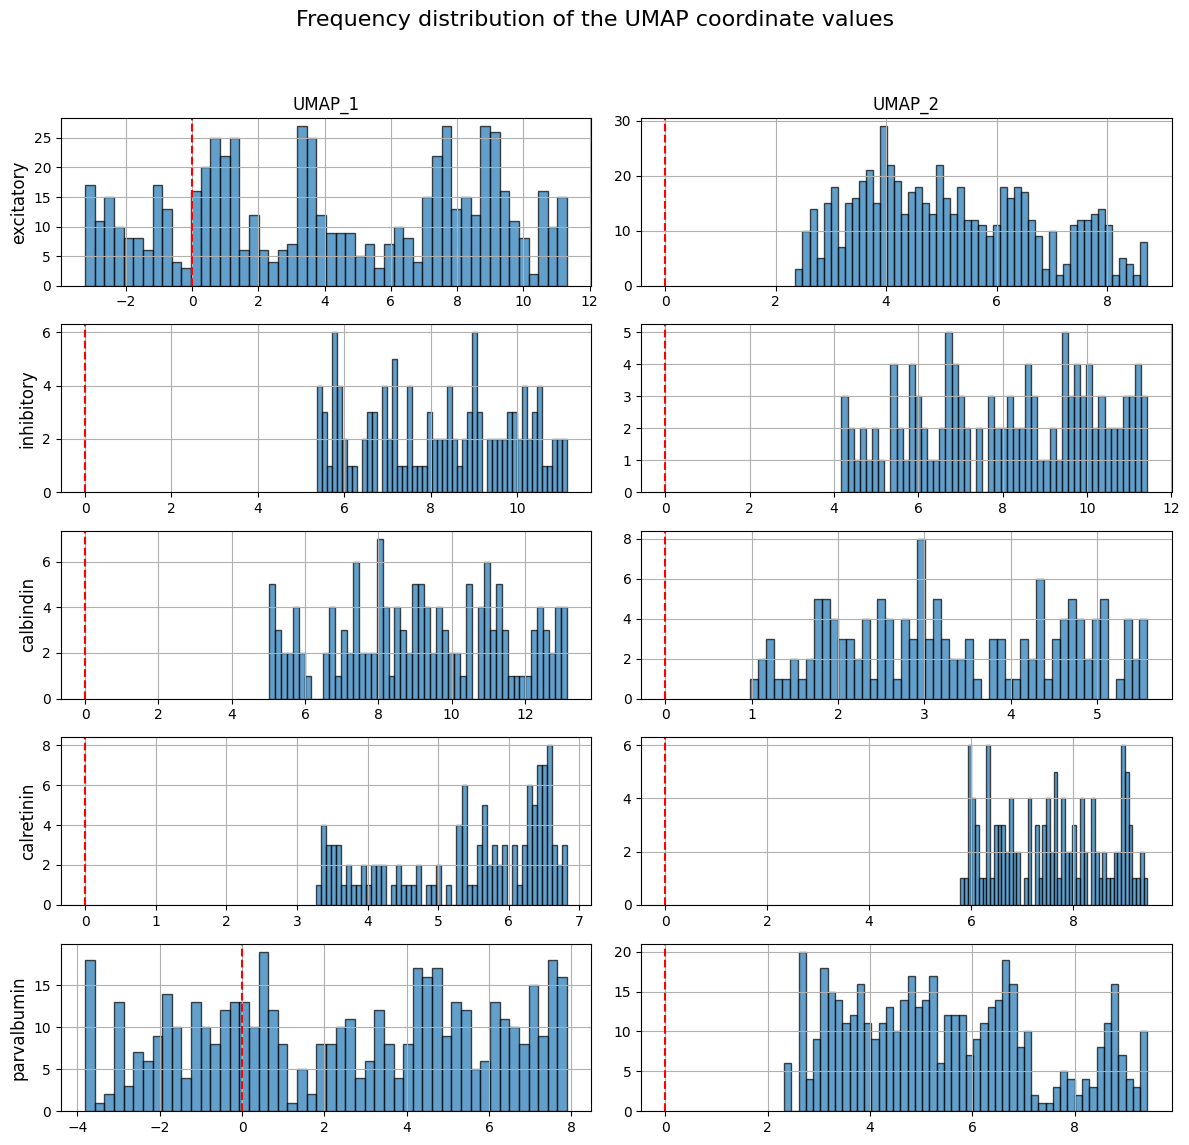

In [46]:
# Designate labels
cluster_labels = {
    'as': 'excitatory',
    'ss': 'inhibitory',
    'cb': 'calbindin',
    'cr': 'calretinin',
    'pv': 'parvalbumin'
}

columns_to_plot = ['UMAP_1', 'UMAP_2']
n_rows = len(cluster_labels)
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 12), sharex=False)

# 2. Plot for all clusterids
for row_idx, (clusterid, label) in enumerate(cluster_labels.items()):
    df_sub = df_neuron_cluster[df_neuron_cluster['clusterid'] == clusterid]
    
    for col_idx, col in enumerate(columns_to_plot):
        ax = axes[row_idx, col_idx]
        df_sub[col].hist(ax=ax, bins=50, edgecolor='black', alpha=0.7)
        ax.axvline(0, color='red', linestyle='--', linewidth=1.5)
        
        # Titles
        if row_idx == 0:
            ax.set_title(f'{col}', fontsize=12)
        if col_idx == 0:
            ax.set_ylabel(label, fontsize=12)

fig.suptitle('Frequency distribution of the UMAP coordinate values', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Correlation Analysis**

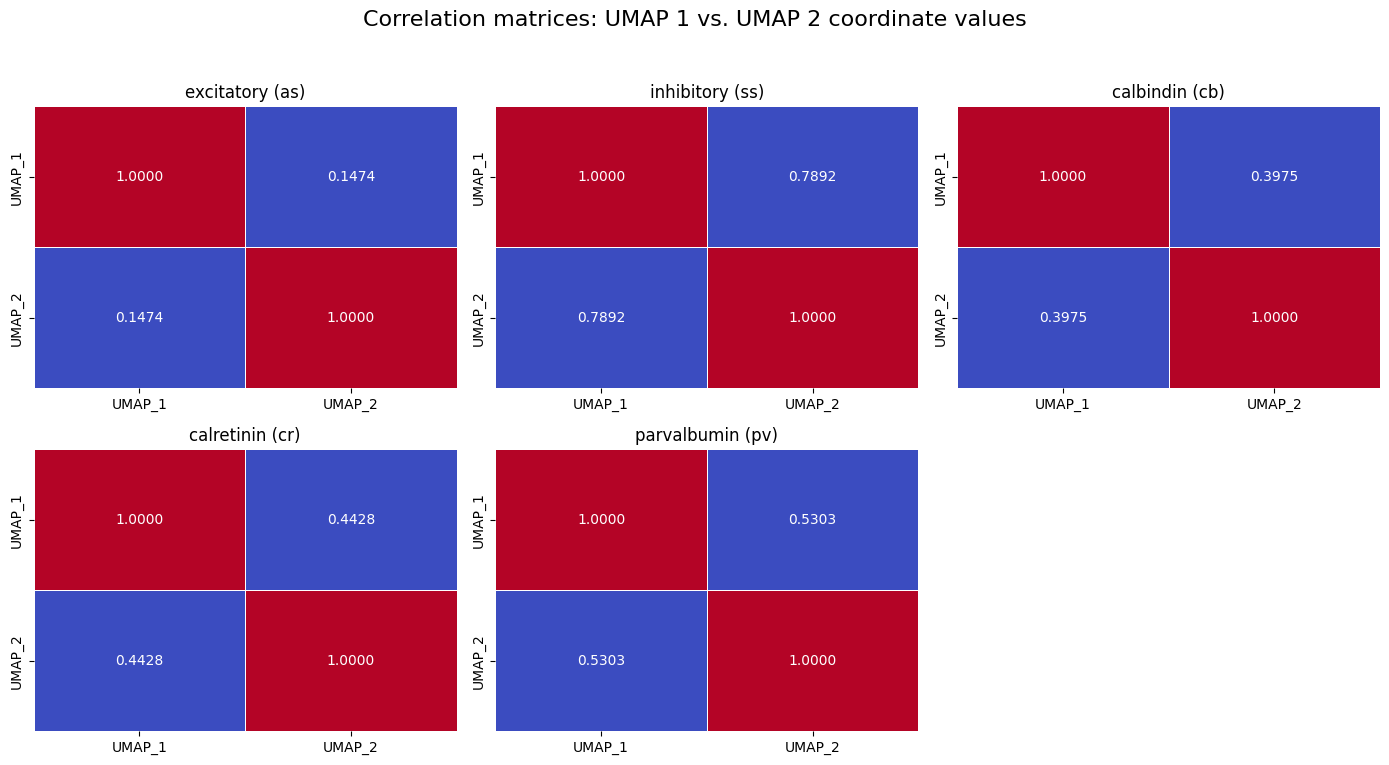

In [47]:
cluster_labels = {
    'as': 'excitatory',
    'ss': 'inhibitory',
    'cb': 'calbindin',
    'cr': 'calretinin',
    'pv': 'parvalbumin'
}

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, (clusterid, label) in enumerate(cluster_labels.items()):
    df_sub = df_neuron_cluster[df_neuron_cluster['clusterid'] == clusterid]
    corr = df_sub[['UMAP_1', 'UMAP_2']].corr()

    sns.heatmap(
        corr,
        annot=True,
        cmap='coolwarm',
        fmt='.4f',
        linewidths=0.5,
        cbar=False,
        ax=axes[i]
    )
    axes[i].set_title(f'{label} ({clusterid})')

for j in range(len(cluster_labels), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Correlation matrices: UMAP 1 vs. UMAP 2 coordinate values', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Correlation was not revealed between UMAP_1 and UMAP_2.

### IV.1.5 Testing supervised models

#### IV.1.5.1 **Excitatory ('as') synapses**

In [48]:
as_train = df_neuron_cluster[df_neuron_cluster['clusterid'] == 'as']

In [57]:
as_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 631 entries, 0 to 630
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SynId       631 non-null    int64  
 1   NeuronType  631 non-null    object 
 2   NeuronId    631 non-null    object 
 3   SynType     631 non-null    object 
 4   UMAP_1      631 non-null    float64
 5   UMAP_2      631 non-null    float64
 6   Cluster     631 non-null    int64  
 7   clusterid   631 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 44.4+ KB


**K-Nearest Neighbors (KNN)**

Short explanation of the definition used below (see train.py):

*Outlier detection (One-Class SVM)*
A One-Class SVM is trained on the scaled training data to identify out-of-distribution synapses, which are excluded from standard KNN classification.

*Hyperparameter tuning (GridSearchCV)*
The optimal number of neighbors and distance metric for the KNN model are selected using cross-validation and micro-averaged F1 score.

*Final prediction and evaluation*
The tuned KNN model assigns cluster labels to inlier synapses, while outliers are flagged separately, and performance is evaluated using standard classification metrics.

In [58]:
as_data = split_umap_data(as_train)
y_test_as = as_data['y_as_test']
as_model_knn, y_pred_as = knn_with_outlier_filtering(as_data, label='as', nu=0.03, k_range=(1, 30, 2), cv=5)

Optimal K: 3, Metric: manhattan

Classification Report:
              precision    recall  f1-score   support

          -1       0.33      0.40      0.36         5
           1       1.00      0.96      0.98        53
           2       0.91      1.00      0.95        21
           3       1.00      0.96      0.98        24
           4       0.96      0.96      0.96        24

    accuracy                           0.94       127
   macro avg       0.84      0.86      0.85       127
weighted avg       0.95      0.94      0.95       127

Accuracy: 0.9449
Macro F1: 0.8472


**Random Forest**

Short explanation of the definition used below (see train.py)

*Outlier detection and filtering (One-Class SVM)* A One-Class SVM is trained on the scaled training data to identify inlier synapses, which are retained for model training, while outliers are excluded.

*Model training* A Random Forest classifier is trained only on the filtered inlier data to improve robustness against noisy or atypical observations.

*Prediction and evaluation* Test samples identified as outliers are flagged separately, while inliers are classified using the trained model and evaluated with standard performance metrics.

In [59]:
rf_pred_as = random_forest_with_outlier_filtering(
    data_dict=as_data,    
    label='as',           # clusterid
    nu=0.05,              # 5% outlier — covers well 4.2%
    n_estimators=100,     # stable, recommended value according to the value count
    max_depth=10          # limited depth, to avoid overfitting
)


Classification Report:
              precision    recall  f1-score   support

          -1       0.27      0.60      0.38         5
           1       1.00      0.91      0.95        53
           2       0.95      0.95      0.95        21
           3       1.00      0.96      0.98        24
           4       0.96      0.96      0.96        24

    accuracy                           0.92       127
   macro avg       0.84      0.87      0.84       127
weighted avg       0.96      0.92      0.93       127

Accuracy: 0.9213
Macro F1: 0.843


**XGBoost**

Short explanation of definition used below (see train.py)

*Outlier detection and data cleaning (One-Class SVM)* A One-Class SVM is applied to the training and test sets to detect outliers, and only inlier synapses are retained for model training and evaluation.

*Label encoding and model training (XGBoost)* Class labels are encoded numerically, and an XGBoost classifier is trained on the filtered inlier data to perform multi-class cluster prediction.

*Prediction and evaluation* Predictions are generated for inlier test samples, converted back to original labels, and evaluated using accuracy and macro F1-score metrics.

In [60]:
as_model_xgb, y_pred_as, y_test_clean_as = xgboost_with_outlier_filtering(
    data_dict=as_data,
    label='as',
    nu=0.05,
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)


XGBoost + OneClassSVM results (only Inliers):
Accuracy: 0.9508
Macro F1: 0.8931
              precision    recall  f1-score   support

          -1       0.60      0.60      0.60         5
           1       0.94      0.98      0.96        49
           2       0.95      0.90      0.93        21
           3       1.00      0.96      0.98        24
           4       1.00      1.00      1.00        23

    accuracy                           0.95       122
   macro avg       0.90      0.89      0.89       122
weighted avg       0.95      0.95      0.95       122



XGBoost performed best; therefore, its results were displayed in a confusion matrix.

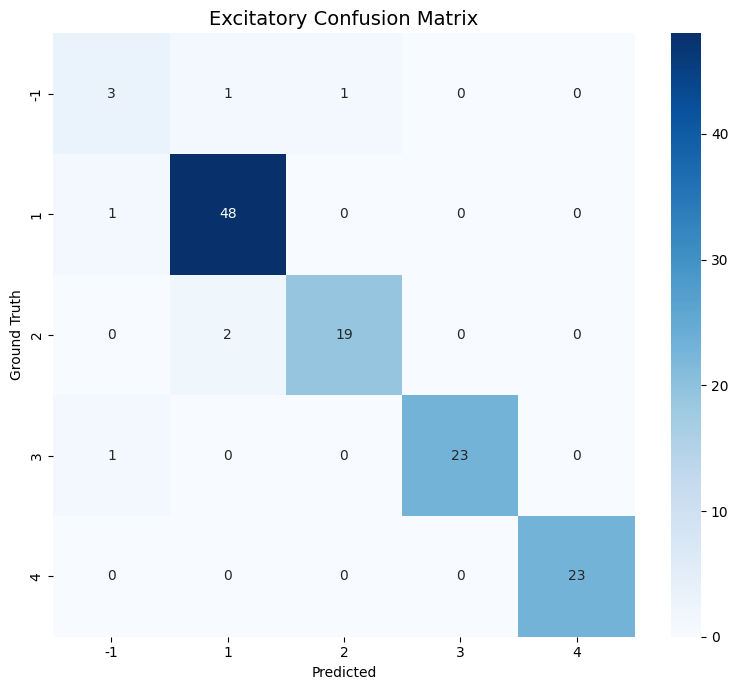

In [61]:
xgboost_plot_confusion_matrix(y_test_clean_as, y_pred_as, title="Excitatory Confusion Matrix")

Saving the model into file

In [62]:

joblib.dump(as_model_xgb, "as_model_xgb.pkl")

['as_model_xgb.pkl']

#### IV.1.5.2 **Inhibitory ('ss') synapses**

In [63]:
ss_train = df_neuron_cluster[df_neuron_cluster['clusterid'] == 'ss']

In [64]:
ss_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, 631 to 747
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SynId       117 non-null    int64  
 1   NeuronType  117 non-null    object 
 2   NeuronId    117 non-null    object 
 3   SynType     117 non-null    object 
 4   UMAP_1      117 non-null    float64
 5   UMAP_2      117 non-null    float64
 6   Cluster     117 non-null    int64  
 7   clusterid   117 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 8.2+ KB


**K-Nearest Neighbors (KNN)**

Optimal K: 1, Metric: euclidean

Classification Report:
              precision    recall  f1-score   support

          -1       0.50      0.50      0.50         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         2
           4       0.88      0.88      0.88         8

    accuracy                           0.92        24
   macro avg       0.88      0.88      0.88        24
weighted avg       0.92      0.92      0.92        24

Accuracy: 0.9167
Macro F1: 0.875


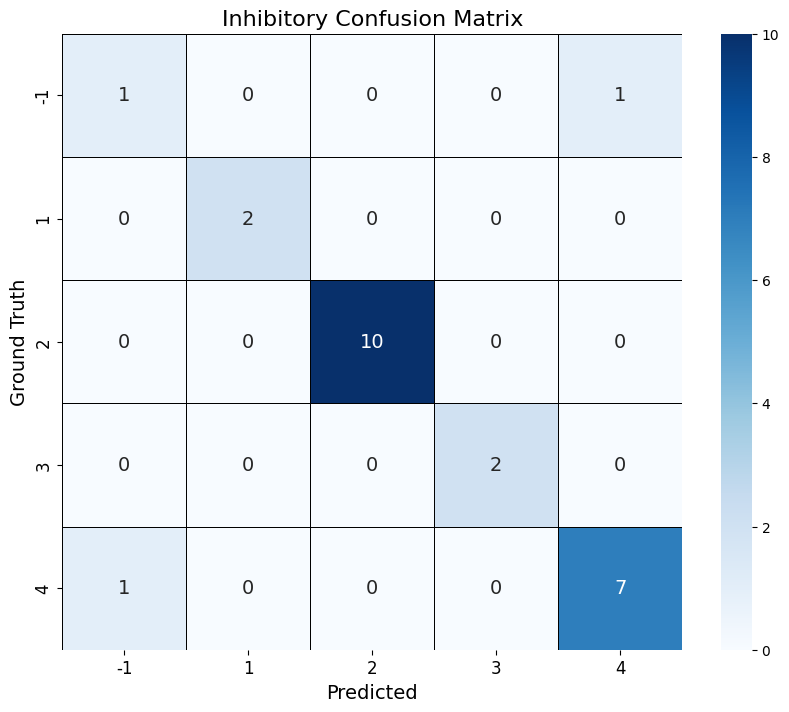

In [65]:
ss_data = split_umap_data(ss_train)
y_test_ss = ss_data['y_ss_test']
ss_model_knn, y_pred_ss = knn_with_outlier_filtering(ss_data, label='ss', nu=0.02, k_range=(1, 10, 2), cv=3)

plot_confusion_matrix(y_test_ss, y_pred_ss, title="Inhibitory Confusion Matrix")

KNN achieved the best performance; therefore, its results are presented using a confusion matrix.

Saving model into file

In [66]:
joblib.dump(ss_model_knn, "ss_model_knn.pkl")

['ss_model_knn.pkl']

**Random Forest**

In [67]:
rf_pred_ss = random_forest_with_outlier_filtering(
    data_dict=ss_data,
    label='ss',
    nu=0.05,              
    n_estimators=200,     
    max_depth=6           
)


Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         2
           4       0.80      1.00      0.89         8

    accuracy                           0.92        24
   macro avg       0.76      0.80      0.78        24
weighted avg       0.85      0.92      0.88        24

Accuracy: 0.9167
Macro F1: 0.7778


**XGBoost**

In [68]:
ss_model_xgb, y_pred_ss, y_test_clean_ss = xgboost_with_outlier_filtering(
    data_dict=ss_data,
    label='ss',
    nu=0.05,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)


XGBoost + OneClassSVM results (only Inliers):
Accuracy: 0.8261
Macro F1: 0.6444
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         9
           3       1.00      0.50      0.67         2
           4       0.80      1.00      0.89         8

    accuracy                           0.83        23
   macro avg       0.76      0.60      0.64        23
weighted avg       0.84      0.83      0.82        23



#### IV.1.5.3 **Calbindin ('cb') synapses**

In [69]:
cb_train = df_neuron_cluster[df_neuron_cluster['clusterid'] == 'cb']

In [70]:
cb_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142 entries, 748 to 889
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SynId       142 non-null    int64  
 1   NeuronType  142 non-null    object 
 2   NeuronId    142 non-null    object 
 3   SynType     142 non-null    object 
 4   UMAP_1      142 non-null    float64
 5   UMAP_2      142 non-null    float64
 6   Cluster     142 non-null    int64  
 7   clusterid   142 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 10.0+ KB


**K-Nearest Neighbors (KNN)**

In [71]:
cb_data = split_umap_data(cb_train)
y_test_cb = cb_data['y_cb_test']
cb_model_knn, y_pred_cb = knn_with_outlier_filtering(cb_data, label='cb', nu=0.01, k_range=(1, 15, 2), cv=5)

Optimal K: 5, Metric: manhattan

Classification Report:
              precision    recall  f1-score   support

          -1       0.33      0.40      0.36         5
           1       1.00      0.57      0.73         7
           2       0.83      1.00      0.91         5
           3       0.80      1.00      0.89         4
           4       0.80      0.80      0.80         5
           5       1.00      1.00      1.00         3

    accuracy                           0.76        29
   macro avg       0.79      0.80      0.78        29
weighted avg       0.79      0.76      0.76        29

Accuracy: 0.7586
Macro F1: 0.7815


**Random Forest**

In [72]:
rf_pred_cb = random_forest_with_outlier_filtering(
    data_dict=cb_data,
    label='cb',     
    nu=0.05,                
    n_estimators=200,       
    max_depth=8             
)


Classification Report:
              precision    recall  f1-score   support

          -1       0.44      0.80      0.57         5
           1       1.00      0.57      0.73         7
           2       1.00      0.80      0.89         5
           3       0.80      1.00      0.89         4
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         3

    accuracy                           0.79        29
   macro avg       0.87      0.83      0.83        29
weighted avg       0.88      0.79      0.81        29

Accuracy: 0.7931
Macro F1: 0.8276


**XGBoost**

In [73]:
cb_model_xgb, y_pred_cb, y_test_clean_cb = xgboost_with_outlier_filtering(
    data_dict=cb_data,
    label='cb',
    nu=0.05,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)


XGBoost + OneClassSVM results (only Inliers):
Accuracy: 0.8800
Macro F1: 0.8714
              precision    recall  f1-score   support

          -1       0.67      0.50      0.57         4
           1       1.00      1.00      1.00         5
           2       0.80      0.80      0.80         5
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       0.75      1.00      0.86         3

    accuracy                           0.88        25
   macro avg       0.87      0.88      0.87        25
weighted avg       0.88      0.88      0.87        25



XGBoost performed best; therefore, its results were displayed in a confusion matrix.

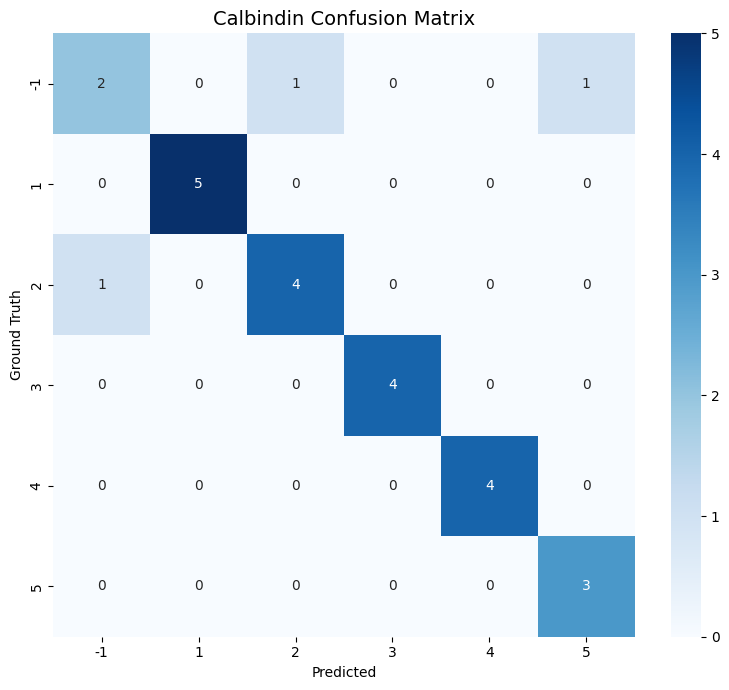

In [74]:
xgboost_plot_confusion_matrix(y_test_clean_cb, y_pred_cb, title="Calbindin Confusion Matrix")

Saving model into file

In [75]:
joblib.dump(cb_model_xgb, "cb_model_xgb.pkl")

['cb_model_xgb.pkl']

#### IV.1.5.4 **Calretinin ('cr') synapses**

In [76]:
cr_train = df_neuron_cluster[df_neuron_cluster['clusterid'] == 'cr']

In [77]:
cr_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 890 to 1008
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SynId       119 non-null    int64  
 1   NeuronType  119 non-null    object 
 2   NeuronId    119 non-null    object 
 3   SynType     119 non-null    object 
 4   UMAP_1      119 non-null    float64
 5   UMAP_2      119 non-null    float64
 6   Cluster     119 non-null    int64  
 7   clusterid   119 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 8.4+ KB


**K-Nearest Neighbors (KNN)**

Optimal K: 1, Metric: euclidean

Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         1
           1       1.00      0.88      0.93         8
           2       0.80      0.67      0.73         6
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         7

    accuracy                           0.83        24
   macro avg       0.76      0.71      0.73        24
weighted avg       0.91      0.83      0.87        24

Accuracy: 0.8333
Macro F1: 0.7321


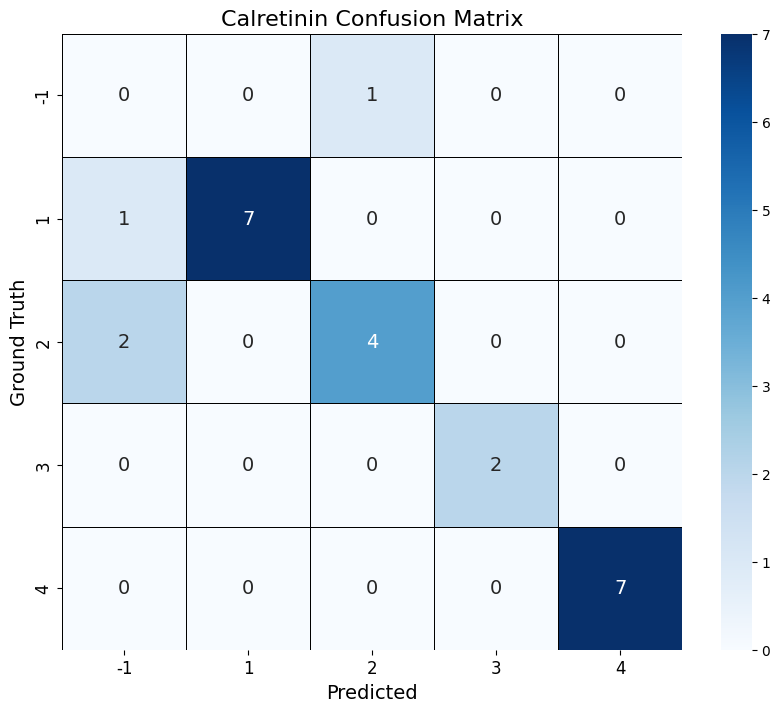

In [78]:
cr_data = split_umap_data(cr_train)
y_test_cr = cr_data['y_cr_test']
cr_model_knn, y_pred_cr = knn_with_outlier_filtering(cr_data, label='cr', nu=0.01, k_range=(1, 15, 2), cv=5)

plot_confusion_matrix(y_test_cr, y_pred_cr, title="Calretinin Confusion Matrix")

KNN achieved the best performance; therefore, its results are presented using a confusion matrix.

Saving model into file

In [79]:
joblib.dump(cr_model_knn, "cr_model_knn.pkl")

['cr_model_knn.pkl']

**Random Forest**

In [80]:
rf_pred_cr = random_forest_with_outlier_filtering(
    data_dict=cr_data,
    label='cr',
    nu=0.01,               
    n_estimators=50,       
    max_depth=5,           
    random_state=42
)


Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         1
           1       1.00      0.88      0.93         8
           2       0.75      0.50      0.60         6
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         7

    accuracy                           0.79        24
   macro avg       0.68      0.68      0.67        24
weighted avg       0.87      0.79      0.82        24

Accuracy: 0.7917
Macro F1: 0.6667


**XGBoost**

In [81]:
cr_model_xgb, y_pred_cr, y_test_clean_cr = xgboost_with_outlier_filtering(
    data_dict=cr_data,
    label='cr',
    nu=0.01,
    n_estimators=50,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)


XGBoost + OneClassSVM results (only Inliers):
Accuracy: 0.7143
Macro F1: 0.5647
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         1
           1       0.70      1.00      0.82         7
           2       1.00      0.50      0.67         4
           3       0.50      1.00      0.67         2
           4       0.80      0.57      0.67         7

    accuracy                           0.71        21
   macro avg       0.60      0.61      0.56        21
weighted avg       0.74      0.71      0.69        21



#### IV.1.5.5 **Parvalbumin ('pv') synapses**

In [82]:
pv_train = df_neuron_cluster[df_neuron_cluster['clusterid'] == 'pv']

In [83]:
pv_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 487 entries, 1009 to 1495
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SynId       487 non-null    int64  
 1   NeuronType  487 non-null    object 
 2   NeuronId    487 non-null    object 
 3   SynType     487 non-null    object 
 4   UMAP_1      487 non-null    float64
 5   UMAP_2      487 non-null    float64
 6   Cluster     487 non-null    int64  
 7   clusterid   487 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 34.2+ KB


**K-Nearest Neighbors (KNN)**

Optimal K: 3, Metric: euclidean

Classification Report:
              precision    recall  f1-score   support

          -1       0.53      1.00      0.70         8
           1       1.00      0.95      0.98        44
           2       1.00      0.88      0.94        25
           3       1.00      0.75      0.86         8
           4       1.00      1.00      1.00        13

    accuracy                           0.93        98
   macro avg       0.91      0.92      0.89        98
weighted avg       0.96      0.93      0.94        98

Accuracy: 0.9286
Macro F1: 0.8931


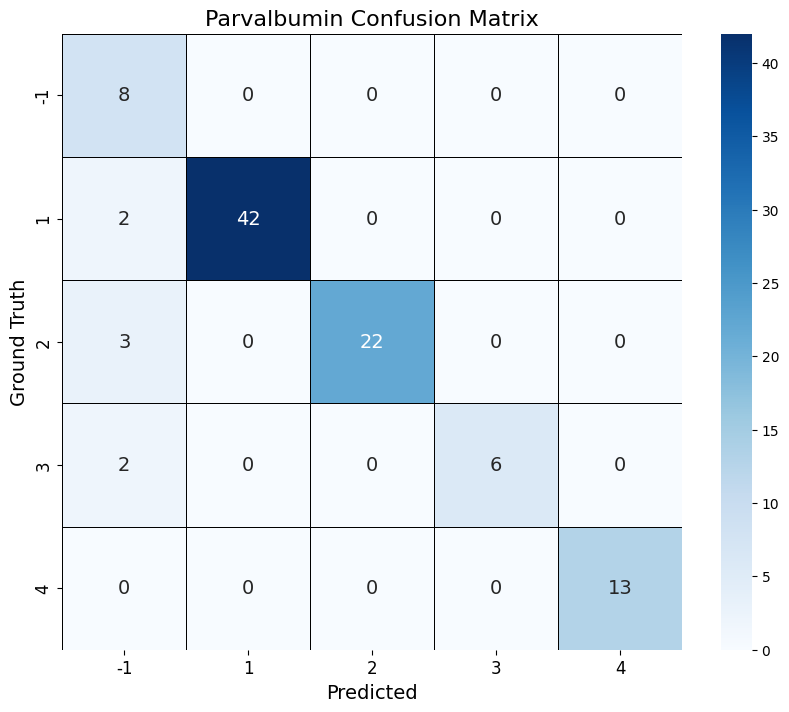

In [84]:
pv_data = split_umap_data(pv_train)
y_test_pv = pv_data['y_pv_test']
pv_model_knn, y_pred_pv = knn_with_outlier_filtering(pv_data, label='pv', nu=0.02, k_range=(1, 25, 2), cv=5)

plot_confusion_matrix(y_test_pv, y_pred_pv, title="Parvalbumin Confusion Matrix")

KNN achieved the best performance; therefore, its results are presented using a confusion matrix.

Saving model into file

In [85]:
joblib.dump(pv_model_knn, "pv_model_knn.pkl")

['pv_model_knn.pkl']

**Random Forest**

In [86]:
rf_pred_pv = random_forest_with_outlier_filtering(
    data_dict=pv_data,            # például cr_data
    label='pv',              # például 'cr'
    nu=0.1,                   # → kb. illeszkedik a 8.8%-os noise arányhoz
    n_estimators=100,         # → elégséges erdőméret közepes adathoz
    max_depth=8,              # → elég mély, de nem túl mély, csökkenti a túltanulást
    random_state=42
)


Classification Report:
              precision    recall  f1-score   support

          -1       0.27      0.75      0.40         8
           1       1.00      0.82      0.90        44
           2       0.95      0.84      0.89        25
           3       0.83      0.62      0.71         8
           4       1.00      0.92      0.96        13

    accuracy                           0.82        98
   macro avg       0.81      0.79      0.77        98
weighted avg       0.92      0.82      0.85        98

Accuracy: 0.8163
Macro F1: 0.7736


**XGBoost**

In [87]:
pv_model_xgb, y_pred, y_test_clean = xgboost_with_outlier_filtering(
    data_dict=pv_data,
    label='pv',
    nu=0.1,
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    random_state=42
)


XGBoost + OneClassSVM results (only Inliers):
Accuracy: 0.9080
Macro F1: 0.8749
              precision    recall  f1-score   support

          -1       0.71      0.62      0.67         8
           1       0.90      1.00      0.95        37
           2       0.95      0.84      0.89        25
           3       0.83      1.00      0.91         5
           4       1.00      0.92      0.96        12

    accuracy                           0.91        87
   macro avg       0.88      0.88      0.87        87
weighted avg       0.91      0.91      0.91        87



#### IV.1.5.5 **Final training performance**

| Metric         | as (excitatory) | ss (inhibitory) | calbindin | calretinin | parvalbumin |
|----------------|----------------|-----------------|-----------|------------|-------------|
| Data count     | 643            | 121             | 149       | 119        | 496         |
| Noise count    | 27             | 8               | 22        | 3          | 43          |
| UMAP component | 2              | 2               | 2         | 3          | 2           |
| Model          | XGBoost        | KNN             | XGBoost   | KNN        | KNN         |
| Accuracy       | 0.9508         | 0.9167          | 0.8800    | 0.8333     | 0.9286      |
| Macro F1       | 0.8931         | 0.8750          | 0.8714    | 0.7321     | 0.8931      |
| Performance    | STRONG         | STRONG          | STRONG    | WEAK       | STRONG      |

The weak performance observed for calretinin synapses is likely caused by the relatively low sample size and higher variability in the data. Increasing the number of observations could improve model stability and predictive performance.
